# Imports

In [1]:
! pip install langchain_pinecone
!pip install pinecone sentence-transformers
! pip install langchain_community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
! pip install rouge_score
! pip install bert_score
! pip install datasets
! python -m spacy download en_core_web_md

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f81cf813b5f4b57a3cea8641a2fc60e4f9d1c79c6d36d0f5f965030314954661
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 78.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
from datasets import Dataset, DatasetDict
import pprint
import json
import logging
logging.basicConfig(level=logging.DEBUG,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
                    format='%(asctime)s - %(levelname)s - %(message)s')  # Define log message format
logger = logging.getLogger(__name__)

import torch
import ast
from collections import Counter

import re
from sentence_transformers import SentenceTransformer

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PINECONE INDEX SET UP

In [5]:
from google.colab import userdata
PINECONE = userdata.get('PINECONE')
#print(PINECONE)

In [6]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE, environment="us-west1-gcp")

In [7]:

index_name = "rag-trainset-index"
indices = [index["name"] for index in pc.list_indexes()]
if index_name not in indices:
  pc.create_index(
      name=index_name,
      dimension=1024,
      metric="cosine",
      spec=ServerlessSpec(
          cloud="aws",
          region="us-east-1"
      )
)

  print(f"Index {index_name} created successfully.")
else:
  print(f"Index {index_name} already exists.")
index = pc.Index(index_name)

Index rag-trainset-index already exists.


In [8]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 411857}},
 'total_vector_count': 411857,
 'vector_type': 'dense'}

# check results for Naive RAG: including train and Pubmed data

In [9]:
# load test

json_file_path = '/content/drive/MyDrive/NLP/00_Data/test_dataset_balanced_shuffled.json'

with open(json_file_path, 'r') as file:
    testset = json.load(file)


testset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in testset.items()
})



In [10]:
print(testset.keys())
pprint.pp(testset['multiple_choice'][0])

dict_keys(['true_false', 'multiple_choice', 'short_answer', 'multi_hop'])
{'correct_answer': 'A',
 'options': {'A': 'Persistent corpus luteum',
             'B': 'Deficient corpus luteum',
             'C': 'Persistent trophoblast',
             'D': 'Deficient trophoblast',
             'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}


# extracting content from user query to match metadata


In [11]:
! pip install spacy

In [12]:
import spacy
model_path = "/content/drive/MyDrive/NLP/03_Training/en_ner_bc5cdr_md-0.5.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.5.4"
nlp = spacy.load(model_path)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [13]:
import re

def categorize_age(age_text):
    """Categorize the extracted age into predefined age groups."""
    # Remove non-numeric characters for age extraction
    age_text = re.sub(r'\D', '', age_text)

    try:
        age = int(age_text)
    except ValueError:
        return None

    # Define age categories
    if age <= 2:
        return 'baby'
    elif age <= 4:
        return 'toddler'
    elif age <= 12:
        return 'child'
    elif age <= 19:
        return 'teen'
    elif age <= 64:
        return 'adult'
    elif age >= 65:
        return 'elderly'

    return None

def extract_age_gender(text):
    """Extract age and gender-related information from the text."""

    # Gender extraction logic: identify pronouns and words related to gender
    gender = None
    for word in text.split():
        if word.lower() == 'he' or word.lower() == 'man' or word.lower() == 'male':
            gender = 'male'
        elif word.lower() == 'she' or word.lower() == 'woman' or word.lower() == 'female':
            gender = 'female'
        elif word.lower() == 'child' or word.lower() == 'boy' or word.lower() == 'girl':
            gender = 'child'  # If 'child' is mentioned, set gender as 'child'
    if 'elderly' in text.lower():
        return ['elderly'], gender
    if 'baby' in text.lower():
        return ['baby'], gender
# Only extract age if a gender is found
    if gender:

        # Updated regex pattern to handle multiple age formats
        age_pattern = r'(\d{1,2}\s*(?:[-to]\s*\d{1,2})?\s*(years?\s*old|yrs?|yr|yrs?|yo|age)?|\bin\s*his\s*\d{1,2}s?|\d{1,2}\s*[-to]\s*\d{1,2}\syears?)'

        # Find potential age mentions using regex
        age_matches = re.findall(age_pattern, text, flags=re.IGNORECASE)
        ages = [match[0] for match in age_matches] if age_matches else []

        # Categorize each extracted age into predefined groups
        categorized_ages = [categorize_age(age) for age in ages if categorize_age(age)]

        return categorized_ages, gender
    else:
        return [], None

In [14]:
def extract_keywords_and_entities(text):
    doc = nlp(text)

    # Extract diseases (e.g., DISEASE or MEDICAL_CONDITION)
    diseases = [ent.text for ent in doc.ents if ent.label_ in ['DISEASE', 'MEDICAL_CONDITION']]

    # Extract symptoms (custom entity, assuming it's labeled as 'SYMPTOM')
    symptoms = [ent.text for ent in doc.ents if ent.label_ == 'SYMPTOM']

    # Extract procedures (e.g., PRODUCT for drugs, medical devices, etc.)
    procedures = [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT']
    # Combine diseases, symptoms, and procedures into a set (for faster lookups)
    medical_entities = set(diseases + symptoms + procedures)

    # Extract keywords, making sure they are not already in the medical_entities set
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']

    # You can also extract noun phrases (more complex terms) if you want
    noun_phrases = [chunk.text for chunk in doc.noun_chunks]

    # Combine nouns and noun phrases for a more comprehensive set of keywords
    potential_keywords = nouns + noun_phrases

    # Filter out already identified medical entities (diseases, symptoms, procedures)
    keywords = [word for word in potential_keywords if word not in medical_entities]
    keyword_counts = Counter(keywords)
    sorted_keywords = [item[0] for item in keyword_counts.most_common(10)]
    return sorted_keywords, diseases, symptoms, procedures

# GENERATION

In [15]:
def build_prompt(prompt_style: str, question: str):
  return prompt_style.replace("{_question_var_}", question)


def generate_model_input(example):

    if example['type'] == 'multiple_choice':
      prompt_style_multiple_choice = """
      "{_question_var_}"

      ### What is the correct answer? Please state only the letter:
      """
      question = example['question']
      options = example['options']

      model_input = question + '\nOptions:\n'
      for key, val in options.items():
          model_input += f"{key}. {val}\n"

      example['prompt'] = build_prompt(prompt_style_multiple_choice, model_input)
      example["answer"] = example.pop("correct_answer")
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'true_false':
      prompt_style_true_false = """
      "{_question_var_}"

      ### Is this statement true or false? Please state only False or True:
      """
      example['prompt'] = build_prompt(prompt_style_true_false, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'short_answer':
      prompt_style_short_answer = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer:
      """
      example['prompt'] = build_prompt(prompt_style_short_answer, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'multi_hop':
      prompt_style_multi_hop = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:
      """
      example['prompt'] = build_prompt(prompt_style_multi_hop, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    return example

In [16]:

json_file_path = '/content/drive/MyDrive/NLP/04_RAG/TopicModeling/PubMed_raw/pubmed_sample_prepro.jsonl'

pubmed_data_all = []
with open(json_file_path, 'r') as file:
    for line in file:
        pubmed_data_all.append(json.loads(line))


In [17]:
pubmed_data_all[0]

{'id': 'pubmed_466957',
 'title': '[Retention of 241Am in the rat and the Syrian hamster].',
 'content': 'The retention of 241-Am during the first three months after injection as well as its microdistribution on the 2nd day were investigated in the rat and the Syrian hamster. Deposition, retention and microdistribution in the skeleton of both species are virtually identical; the same holds for kidneys, except for a higher initial deposition in the hamster. The microdistribution of 241-Am in kidneys and liver of both species is homogenous with a distinct accumulation in the cortical zone of the kidneys. A pronounced difference was observed with regard to the elimination of 241-Am from the liver: Most of the 241-Am is excreted by the rat liver with a half time of 7 days whereas this value is about 150 days for the Syrian hamster. The consequences of the species differences are discussed.',
 'contents': '[Retention of 241Am in the rat and the Syrian hamster]. The retention of 241-Am durin

In [18]:
# # Step 1: Create a lookup dictionary for pubmed_data_15 by ID
# pubmed_data_15_dict = {item["id"]: item for item in pubmed_data_15}

# # Step 2: Update content efficiently
# for item in pubmed_data_all:
#      item_id = item["id"]
#      if item_id in pubmed_data_15_dict:
#          pubmed_data_15_dict[item_id]["content"] = item["content"]



In [19]:
# with open('/content/drive/MyDrive/NLP/04_RAG/TopicModeling/PubMed_raw/pubmed_data_15.json', 'w') as json_file:
#     json.dump(pubmed_data_15_dict, json_file)



In [20]:
import json

json_file_path = '/content/drive/MyDrive/NLP/04_RAG/TopicModeling/PubMed_raw/pubmed_data_15.json'

with open(json_file_path, 'r') as file:
    pubmed_data_15 = json.load(file)


In [21]:

json_file_path = '/content/drive/MyDrive/NLP/00_Data/train_dataset_rag_w_id.json'

with open(json_file_path, 'r') as file:
    data = json.load(file)


data = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in data.items()
})


In [22]:
data["multiple_choice"][0]

{'correct_answer': '2-3 year after eruption',
 'options': {'A': '1-1 ½ year after eruption',
  'B': '2-3 year after eruption',
  'C': '6 months after eruption',
  'D': 'None of the above',
  'E': None},
 'question': 'Root completion of permanent tooth occurs',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'id': 'mc_0'}

In [23]:
testset = testset.map(generate_model_input)

Map:   0%|          | 0/5971 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

In [24]:
model_pipeline = None
embedding_pipe = None

In [25]:
sources = set()
for split, split_data in data.items():
  for entry in split_data:
    sources.add(entry['source'])

sources = dict.fromkeys(sources, 0)
sources['PubMed'] = 0

### building a hybrid advanced retriever on top of the simple get_retriever

In [26]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")
index = pc.Index(index_name)

<ipython-input-26-7d73563f437d>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [27]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, Runnable

from langchain_community.embeddings import HuggingFaceEmbeddings

from langchain_pinecone import PineconeVectorStore
#from langchain_community.vectorstores import Pinecone as PineconeVectorStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema.output_parser import StrOutputParser
import pinecone
import os



from langchain.schema import Document


def get_hybrid_retriever():


    # 2) wrap query logic in a custom retriever
    class HybridRetriever(Runnable):
        def __init__(self, index, embedder):
            self.index = index
            self.embedder = embedder

        # Implement the invoke method for the Runnable interface
        def invoke(self, query: str, config=None):
             return self.get_relevant_documents(query)

        def get_relevant_documents(self, query: str, k: int = 5):
            # 3) extract metadata from the query
            kw, diseases, symptoms, procedures = extract_keywords_and_entities(query)
            ages, gender                  = extract_age_gender(query)

            # print(f"\nQuery: {query!r}")
            # print("  → keywords:  ", kw)
            # print("  → diseases:  ", diseases)
            # print("  → symptoms:  ", symptoms)
            # print("  → procedures:", procedures)
            # print("  → ages:      ", ages)
            # print("  → gender:    ", gender)



            # 4) build a Pinecone filter only on the fields you got back
            flt = {}
            if diseases:   flt["diseases"]   = {"$in": diseases}
            if symptoms:   flt["symptoms"]   = {"$in": symptoms}
            if procedures: flt["procedures"] = {"$in": procedures}
            if kw:         flt["keywords"]   = {"$in": kw}
            if ages:       flt["age"]        = {"$in": ages}
            if gender:     flt["gender"]     = {"$eq": gender}

            # 5) get the query embedding
            vec = self.embedder.embed_query(query)

            # 6) call Pinecone with both vector + filter
            filtered_resp = self.index.query(
                vector=vec,
                top_k=k,
                filter=flt,
                include_metadata=True
            )
            # search without filter
            unfiltered_resp = self.index.query(
                vector=vec,
                top_k=k,
                include_metadata=True
            )

                    # collect unique results from both (by ID)
            seen_ids = set()
            docs = []

            def add_matches(matches):
                for match in matches:
                    if match.id not in seen_ids:
                        seen_ids.add(match.id)
                        docs.append(Document(
                            page_content="", metadata=match.metadata or {"id": match.id}
                        ))

            add_matches(filtered_resp.matches)
            add_matches(unfiltered_resp.matches)

            return docs[:k]
    return HybridRetriever(index, embedder)


In [28]:


def load_deepseek_model(model_id="deepseek-ai/deepseek-coder-7b-instruct-v1.5"):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",  # Automatically places model layers on available GPUs
        torch_dtype=torch.float16  # Use float16 for reduced memory usage
    )

    # Create the pipeline for text generation
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer) # Assuming you're using GPU 0
    return pipe



def get_prompt():
    template = """
    Context:
    {context}

    {question}
    """

    return PromptTemplate(
        input_variables=["context", "question"],
        template=template.strip()
    )


def get_retriever():
    return get_hybrid_retriever()



# Build QA chain
def build_qa_chain(retriever):
    from langchain_community.llms import HuggingFacePipeline
    from transformers import pipeline

    # # load model only once
    global model_pipeline


    if model_pipeline is None:
      #### FIRST V: WORKING!
    #     pipe = pipeline(
    #         "text-generation",
    #         model="deepseek-ai/deepseek-coder-7b-instruct-v1.5",
    #         device=0,
    #         max_new_tokens=512,
    #         #temperature=0.2,
    #         do_sample=True,
    #         torch_dtype=torch.float16  # Use torch.float16 for reduced memory usage
    #     )
    #     model_pipeline = HuggingFacePipeline(pipeline=pipe)


          ## KONSTI
          model_id = "deepseek-ai/deepseek-coder-7b-instruct-v1.5"  # or any other DeepSeek model
          tokenizer = AutoTokenizer.from_pretrained(model_id)
          model = AutoModelForCausalLM.from_pretrained(model_id,
                                                      device_map="auto",
                                                      torch_dtype=torch.float16)

          pipe = pipeline("text-generation", model=model, tokenizer=tokenizer,
                          # max_new_tokens=20,
                          # temperature=0.1,
                          # top_p=0.9,
                          # top_k=50,
                          # do_sample=True
                           max_new_tokens=100, # setup for sa with 100 new tokens, mh same params but 200 max new tokens
                           temperature=0.7,
                           top_p=0.9,
                           top_k=50,
                           do_sample=True
                          )
          model_pipeline = HuggingFacePipeline(pipeline=pipe)





    llm = model_pipeline

    prompt = get_prompt()

    def log_and_format(inputs, prompt):


        #print("inputs:")
        #pprint.pp(inputs)

        #Extracting the ids from the retrieved context and retrieve the text from the drive data
        input_str = inputs['context']
        content = []
        for string in input_str:

              # Regular expression to find all `id='some_value'`
              # id = re.findall(r"'id': '([a-zA-Z]{2}_\d+)'", string)

              id = string.metadata['id']

              #print("ID von context: ", id)
              if id.startswith("mc"):
                doc = data['multiple_choice'][int(id[3:])]
                # Ensure that `content` is a string
                content.append(doc.get('question', '') + " " + doc.get('answer', ''))  # Concatenate string if needed
                source = doc['source']
                sources[source] += 1

              elif id.startswith("sa"):
                doc = data['short_answer'][int(id[3:])]
                # Ensure that `content` is a string
                content.append(doc.get('question', '') + " " + doc.get('answer', ''))
                source = doc['source']
                sources[source] += 1

              elif id.startswith("tf"):
                doc = data['true_false'][int(id[3:])]
                # Ensure that `content` is a string
                content.append(doc.get('question', '') + " " + doc.get('answer', ''))
                source = doc['source']
                sources[source] += 1

              elif id.startswith("mh"):
                doc = data['multi_hop'][int(id[3:])]
                # Ensure that `content` is a string
                content.append(doc.get('question', '') + " " + doc.get('answer', ''))
                source = doc['source']
                sources[source] += 1

              # NEW for pubmed data here
              elif id.startswith("pubmed"):
                doc = pubmed_data_15[id]["content"]
                # Ensure that `content` is a string
                content.append(doc)
                source = "PubMed"
                sources[source] += 1

        #print("Content wird jetzt verarbeitet")
       # print(content)
        content = {
              'role': 'system',
              'content': "\n".join(content)
        }
        if not content:
          print("Warning: No content extracted!")
        # else:
          # print("Extracted content:")
          # pprint.pp(content['content'])

        inputs['context'] = content['content']

        rendered = prompt.format(**inputs)
        #logger.info(f"\n Prompt sent to model:\n{rendered}\n")
        #print(f"\n Prompt sent to model:\n{rendered}\n")
        return rendered

    # Function to extract and format context from retrieved documents
    def format_docs(docs):
        # Concatenate the page_content from each document
        return "\n\n".join([doc.page_content for doc in docs])

    chain = (
            {"context": retriever, "question": RunnablePassthrough()}
            | RunnableLambda(lambda x: log_and_format(x, prompt)) # Also covers the addition of the context
            | llm
            | StrOutputParser()
    )


    return chain


In [29]:

def run_rag_pipeline_with_json(question_data):

    # Retrieve 'multiple_choice' questions from the JSON


    # Initialize the retriever and QA chain
    retriever = get_retriever()
    qa_chain = build_qa_chain(retriever)

    results = []


    prompt = question_data['prompt']
    question = question_data['question']
    gold_answer = question_data['answer']
    generated_answer = qa_chain.invoke(prompt)

    # Store the result in a new dictionary (you can include more fields as needed)
    results.append({
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    })


    return results
    # Save the results to a new JSON file
    # output_file_path = './MC_100_generated_answers.json'
    # with open(output_file_path, 'w') as output_file:
    #     json.dump(results, output_file, indent=4)

    # print(f"Results saved to {output_file_path}")


In [30]:
torch.cuda.empty_cache()

# Multiple Choice

## Attention: Reset sources and save for each question type individually++

In [ ]:
sources

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 48,
 'SA1-HPAI-BSC/OpenMedQA': 38,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 626,
 'MC3-openlifescienceai/medmcqa': 3095,
 'SA2-Ajayaadhi/Medical-QA': 317,
 'MC4-UCSC-VLAA/MedReason': 343,
 'MC2-stellalisy/mediQ': 56,
 'TF2-qiaojin/PubMedQA': 134,
 'MC1-bigbio/med_qa': 343,
 'PubMed': 0}

In [ ]:
mc_testset = testset['multiple_choice']
mc_testset = Dataset.to_list(mc_testset)[:1000]

ground_truth = [entry['answer'] for entry in mc_testset]

In [ ]:
mc_testset[0]

{'options': {'A': 'Persistent corpus luteum',
  'B': 'Deficient corpus luteum',
  'C': 'Persistent trophoblast',
  'D': 'Deficient trophoblast',
  'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'prompt': '\n      "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n      ### What is the correct answer? Please state only the letter:\n      ',
 'answer': 'A',
 'prompt_n_answer': '\n      "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n      ### What is the correct answer? Please state only the letter:\n      A'}

In [ ]:
ground_truth[:5]

['A', 'B', 'D', 'B', 'B']

In [ ]:
predictions_multiple_choice = []
for question_data in tqdm(mc_testset):
    response = run_rag_pipeline_with_json(question_data)
    predictions_multiple_choice.append(response)

# output_file_path = '/content/drive/MyDrive/NLP/04_RAG/test_train_pm.json'
# with open(output_file_path, 'w') as output_file:
#     json.dump(predictions_multiple_choice, output_file, indent=4)

# print(f"Results saved to {output_file_path}")

100%|██████████| 1000/1000 [15:00<00:00,  1.11it/s]


- retrieve CHARS out of generated answers

In [ ]:
import re

predicted_answer_multiple_choice = []

pattern = re.compile(
    r'''
    (?:                                       # non-capturing group for the two prompts
      correct\ answers?\ is                   # “correct answer is” or “correct answers is”
      |please\ state\ only\ the\ letter        # or “Please state only the letter”
    )
    \s*[:]*\s*                                # any spaces or colons after the prompt
    (?:\r?\n\s*)*                             # skip any number of blank/indented lines
    ([A-E])                                   # capture exactly one letter A–E
    ''',
    flags=re.IGNORECASE | re.VERBOSE
)


for sample in predictions_multiple_choice:
    gen = sample[0].get('generated_answer') or ""
    m = pattern.search(gen)
    if m:
        predicted_answer_multiple_choice.append(m.group(1))
    else:
        predicted_answer_multiple_choice.append("na")

#print(predicted_answer_multiple_choice)


In [ ]:
predicted_answer_multiple_choice

['A',
 'B',
 'D',
 'A',
 'C',
 'B',
 'D',
 'E',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'A',
 'E',
 'A',
 'A',
 'E',
 'A',
 'E',
 'B',
 'A',
 'E',
 'A',
 'A',
 'A',
 'B',
 'A',
 'B',
 'B',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'C',
 'E',
 'E',
 'A',
 'A',
 'E',
 'D',
 'B',
 'E',
 'E',
 'A',
 'B',
 'E',
 'C',
 'C',
 'B',
 'C',
 'B',
 'E',
 'C',
 'B',
 'B',
 'A',
 'E',
 'E',
 'E',
 'E',
 'A',
 'E',
 'E',
 'D',
 'A',
 'A',
 'A',
 'B',
 'D',
 'A',
 'B',
 'C',
 'E',
 'A',
 'C',
 'A',
 'E',
 'C',
 'A',
 'B',
 'E',
 'E',
 'A',
 'B',
 'A',
 'E',
 'A',
 'A',
 'E',
 'A',
 'E',
 'E',
 'B',
 'E',
 'A',
 'A',
 'E',
 'C',
 'A',
 'A',
 'E',
 'A',
 'B',
 'A',
 'C',
 'C',
 'E',
 'E',
 'D',
 'A',
 'B',
 'E',
 'A',
 'A',
 'A',
 'A',
 'E',
 'E',
 'C',
 'E',
 'A',
 'B',
 'A',
 'A',
 'C',
 'A',
 'E',
 'A',
 'A',
 'A',
 'D',
 'E',
 'B',
 'E',
 'C',
 'A',
 'A',
 'A',
 'E',
 'A',
 'E',
 'E',
 'E',
 'A',
 'B',
 'E',
 'A',
 'A',
 'D',
 'C',
 'D',
 'E',
 'D',
 'B',
 'C',
 'D',
 'D',
 'E',
 'A',
 'A',
 'E'

- apply EVAL SUITE MultipleCHoice

In [ ]:
from evaluation_suite_vf import EvaluationSuite

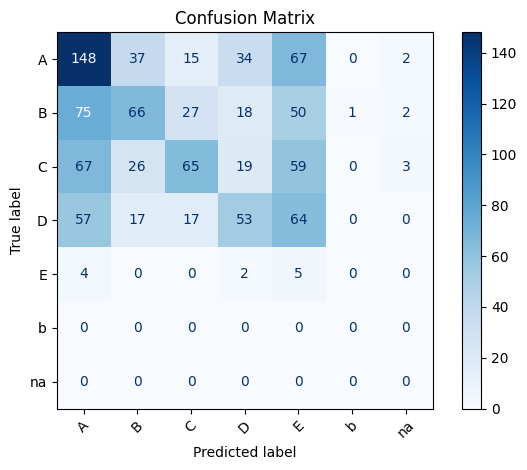

{'accuracy': 0.337,
 'precision': 0.26270626406575615,
 'recall': 0.24941702093562154}

In [ ]:
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="AdvRAG_7bcoder_MC_1000", RAG_sources=sources)

# Short Answer

### Attention: Reset sources and save for each question type individually++

In [31]:
# sources = set()
# for split, split_data in data.items():
#   for entry in split_data:
#     sources.add(entry['source'])

# sources = dict.fromkeys(sources, 0)
# sources['PubMed'] = 0

pprint.pp(sources)

{'SA2-Ajayaadhi/Medical-QA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MC2-stellalisy/mediQ': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'MC1-bigbio/med_qa': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'PubMed': 0}


In [32]:
sa_testset = testset['short_answer']
sa_testset = Dataset.to_list(sa_testset)[:500]

In [33]:
ground_truth_sa = [entry['answer'] for entry in sa_testset[:500]]

In [34]:
# Comment for params for model pipeline (e.g. temperature etc.)
# predictions_sa = []
#
# for i in tqdm(range(500)):

#   pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
#   response = pipe(sa_testset[i]['prompt'],
#                   max_new_tokens=100,
#                   temperature=0.7,
#                   top_p=0.9,
#                   top_k=50,
#                   do_sample=True,
#                   )

#   predictions_sa.append(response)



predictions_sa = []
for question_data in tqdm(sa_testset):
    response = run_rag_pipeline_with_json(question_data)
    predictions_sa.append(response)

  0%|          | 0/500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-28-ee7aab0d8b4b>:77: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  model_pipeline = HuggingFacePipeline(pipeline=pipe)
 24%|██▍       | 120/500 [08:19<22:33,  3.56s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (4105 > 4096). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
100%|██████████| 500/500 [31:43<00:00,  3.81s/it]


In [35]:
predictions_sa[1]

[{'question': 'What are the common characteristics of anterior hip dislocations?',
  'true_answer': 'Anterior hip dislocations are characterized by a flexed, abducted, and externally rotated hip. This means that the thigh bone is angled away from the body, the knee is bent, and the foot is turned outward. Anterior hip dislocations occur when the femoral head (the ball-shaped top of the thigh bone) is forced out of the hip socket in a forward direction. This type of injury is often caused by high-energy trauma, such as a car accident or a fall from a significant height. Anterior hip dislocations are considered a medical emergency and require prompt treatment to prevent complications such as nerve damage, blood vessel injury, or avascular necrosis (death of bone tissue due to lack of blood supply).',
  'generated_answer': 'Context:\n    What are the common characteristics of anterior hip dislocations? Anterior hip dislocations are characterized by a flexed, abducted, and externally rotat

In [36]:
predicted_answer_short_answer = []
blocked_answers = 0
for sample in predictions_sa:
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer:\s*(.+)',
      sample[0].get('generated_answer'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_short_answer.append({"predicted_answer": answer})
  else:
      predicted_answer_short_answer.append({"predicted_answer": "na"})

In [37]:
predicted_answer_sa = [answer['predicted_answer'] for answer in predicted_answer_short_answer]

In [38]:
from evaluation_suite import EvaluationSuite

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [39]:
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(predicted_answer_sa, ground_truth_sa, experiment_name="AdvRAG_7bcoder_SA_500", RAG_sources=sources)

rouge_scores [{'rouge1': 0.416, 'rouge2': 0.2926829268292683, 'rougeL': 0.336}, {'rouge1': 0.8, 'rouge2': 0.7878787878787878, 'rougeL': 0.8}, {'rouge1': 0.6666666666666667, 'rouge2': 0.4724409448818897, 'rougeL': 0.6046511627906977}, {'rouge1': 0.23529411764705885, 'rouge2': 0.07665505226480837, 'rougeL': 0.15916955017301035}, {'rouge1': 0.5296803652968036, 'rouge2': 0.38709677419354843, 'rougeL': 0.4200913242009132}, {'rouge1': 0.4293193717277487, 'rouge2': 0.09523809523809523, 'rougeL': 0.25130890052356025}, {'rouge1': 0.11764705882352941, 'rouge2': 0.024096385542168672, 'rougeL': 0.11764705882352941}, {'rouge1': 0.4719101123595506, 'rouge2': 0.45977011494252873, 'rougeL': 0.4719101123595506}, {'rouge1': 0.38461538461538464, 'rouge2': 0.11764705882352941, 'rougeL': 0.21153846153846154}, {'rouge1': 0.5573770491803279, 'rouge2': 0.26519337016574585, 'rougeL': 0.33879781420765026}, {'rouge1': 0.5656565656565656, 'rouge2': 0.3673469387755102, 'rougeL': 0.4141414141414141}, {'rouge1': 0.4

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.416, 'rouge2': 0.2926829268292683, 'rougeL': 0.336}, {'rouge1': 0.8, 'rouge2': 0.7878787878787878, 'rougeL': 0.8}, {'rouge1': 0.6666666666666667, 'rouge2': 0.4724409448818897, 'rougeL': 0.6046511627906977}, {'rouge1': 0.23529411764705885, 'rouge2': 0.07665505226480837, 'rougeL': 0.15916955017301035}, {'rouge1': 0.5296803652968036, 'rouge2': 0.38709677419354843, 'rougeL': 0.4200913242009132}, {'rouge1': 0.4293193717277487, 'rouge2': 0.09523809523809523, 'rougeL': 0.25130890052356025}, {'rouge1': 0.11764705882352941, 'rouge2': 0.024096385542168672, 'rougeL': 0.11764705882352941}, {'rouge1': 0.4719101123595506, 'rouge2': 0.45977011494252873, 'rougeL': 0.4719101123595506}, {'rouge1': 0.38461538461538464, 'rouge2': 0.11764705882352941, 'rougeL': 0.21153846153846154}, {'rouge1': 0.5573770491803279, 'rouge2': 0.26519337016574585, 'rougeL': 0.33879781420765026}, {'rouge1': 0.5656565656565656, 'rouge2': 0.3673469387755102, 'rougeL': 0.4141414141414141}, {'rouge1': 0

{'avg_bleu': 0.11778065094304797,
 'avg_meteor': 0.29498200734678615,
 'rouge1': 0.3389806442413773,
 'rouge2': 0.21009368650290755,
 'rougeL': 0.2689311848257376,
 'word_similarity': 0.8503310610663216,
 'sentence_similarity': 0.8007892765526502,
 'paragraph_similarity': 0.8503310610663216,
 'semantic_match_score': 0.8354685517976869,
 'precision': 0.8482890129089355,
 'recall': 0.869712769985199,
 'f1': 0.8576815724372864,
 'avg_cosine_similarity': 0.8503310610663216,
 'avg_reasoning_coherence': 0.7272013641753287}

# TrueFalse

### Attention: Reset sources and save for each question type individually++

In [ ]:
sources

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 30,
 'SA1-HPAI-BSC/OpenMedQA': 4,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 78,
 'MC3-openlifescienceai/medmcqa': 290,
 'SA2-Ajayaadhi/Medical-QA': 85,
 'MC4-UCSC-VLAA/MedReason': 17,
 'MC2-stellalisy/mediQ': 4,
 'TF2-qiaojin/PubMedQA': 4482,
 'MC1-bigbio/med_qa': 30,
 'PubMed': 0}

In [ ]:
sources = set()
for split, split_data in data.items():
  for entry in split_data:
    sources.add(entry['source'])

sources = dict.fromkeys(sources, 0)
sources['PubMed'] = 0

pprint.pp(sources)

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'SA2-Ajayaadhi/Medical-QA': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'MC2-stellalisy/mediQ': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'MC1-bigbio/med_qa': 0,
 'PubMed': 0}


In [ ]:
tf_testset = testset['true_false']
tf_testset = tf_testset.shuffle(seed=42)

tf_testset = Dataset.to_list(tf_testset)[:1000]

ground_truth = [entry['answer'] for entry in tf_testset]

In [ ]:
ground_truth[:10]

['False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'True',
 'True',
 'False',
 'False']

In [ ]:
predictions_tf = []
for question_data in tqdm(tf_testset):
    response = run_rag_pipeline_with_json(question_data)
    predictions_tf.append(response)

100%|██████████| 1000/1000 [14:53<00:00,  1.12it/s]


In [ ]:
predicted_answer_true_false = []
for sample in predictions_tf:
  match = re.search(r'Please state only False or True:\s*\n*(True|False)\.*', sample[0].get('generated_answer'), re.IGNORECASE)
  if match:
      answer = match.group(1)
      predicted_answer_true_false.append({"predicted_answer": answer})
  else:
      predicted_answer_true_false.append({"predicted_answer": "na"})


In [ ]:
sources

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 25,
 'SA1-HPAI-BSC/OpenMedQA': 3,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 84,
 'MC3-openlifescienceai/medmcqa': 319,
 'SA2-Ajayaadhi/Medical-QA': 81,
 'MC4-UCSC-VLAA/MedReason': 24,
 'MC2-stellalisy/mediQ': 5,
 'TF2-qiaojin/PubMedQA': 4437,
 'MC1-bigbio/med_qa': 21,
 'PubMed': 1}

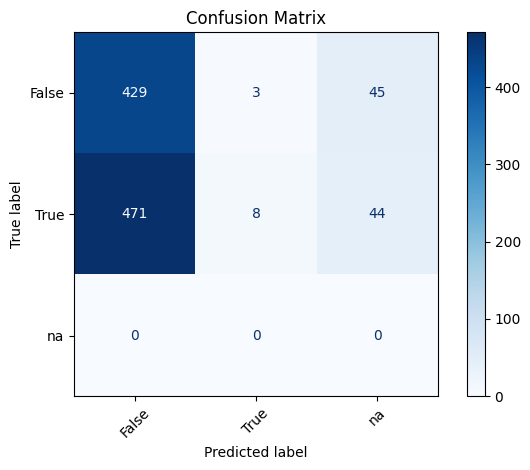

{'accuracy': 0.437,
 'precision': 0.40131313131313134,
 'recall': 0.30488914543173357}

In [ ]:
# Extract predicted and correct answers
y_pred_true_false = [entry['predicted_answer'] for entry in predicted_answer_true_false]
y_true_true_false = [entry['answer'] for entry in tf_testset[:1000]]

evaluation_suite.evaluate_discrete_answers(y_pred_true_false, y_true_true_false, experiment_name="AdvRAG_7bcoder_TF_1000", RAG_sources=sources)

# Multi Hop

### Attention: Reset sources and save for each question type individually++

In [39]:
# sources = set()
# for split, split_data in data.items():
#   for entry in split_data:
#     sources.add(entry['source'])

# sources = dict.fromkeys(sources, 0)
# sources['PubMed'] = 0

sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }


pprint.pp(sources)

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'SA2-Ajayaadhi/Medical-QA': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'MC2-stellalisy/mediQ': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'MC1-bigbio/med_qa': 0,
 'PubMed': 0}


In [40]:
mh_testset = testset['multi_hop']
mh_testset = Dataset.to_list(mh_testset)[:500]

In [41]:
ground_truth_mh = [entry['answer'] for entry in mh_testset[:500]]

In [42]:
# Comment for params for model pipeline (e.g. temperature etc.)
# predictions_sa = []
#
# for i in tqdm(range(500)):

#   pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
#   response = pipe(sa_testset[i]['prompt'],
#                   max_new_tokens=100,
#                   temperature=0.7,
#                   top_p=0.9,
#                   top_k=50,
#                   do_sample=True,
#                   )

#   predictions_sa.append(response)



predictions_mh = []
for question_data in tqdm(mh_testset):
    response = run_rag_pipeline_with_json(question_data)
    predictions_mh.append(response)

  0%|          | 0/500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-28-7446edbf2be1>:77: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  model_pipeline = HuggingFacePipeline(pipeline=pipe)
100%|██████████| 500/500 [56:37<00:00,  6.79s/it]


In [43]:
predictions_mh[1]

[{'question': 'A 27-year-old African American man presents with episodes of severe pain, a lab finding of hemoglobin at 8 g/dL, hematocrit at 28%, a mean corpuscular volume of 72 um^3, and elevated lactate dehydrogenase (LDH) at 540 U/L. Based on these clinical and laboratory findings, what is the most likely explanation for his hemolytic anemia?',
  'true_answer': "The most likely explanation for the patient's hemolytic anemia is sickle cell disease. The episodes of severe pain are characteristic of vaso-occlusive crises commonly seen in sickle cell disease. While the mean corpuscular volume (MCV) is lower than expected for sickle cell anemia, which typically presents as normocytic or macrocytic anemia, this could be due to an additional factor such as iron deficiency, which can cause microcytic anemia. The elevated lactate dehydrogenase (LDH) supports ongoing hemolysis, and the demographic factor of being African American also aligns with sickle cell disease being a common condition 

In [52]:
print(predictions_mh[0][0]['generated_answer'])

Context:
    A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patients enrolled have AD. In the group of patients with AD, 400 are found positive on the novel type of PET imaging examination. In the control group, 50 are found positive. What is the PPV of this novel exam? 
A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patients enrolled have AD. In the group of patients with AD, 400 are found positive on the novel type of PET imaging examination. In the control group, 50 are found positive. What is the PPV of this novel exam? 
A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patie

In [53]:
predicted_answer_mh = []
blocked_answers = 0
for i, sample in enumerate(predictions_mh):
  print(i)
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:\s*(.+)',
      sample[0].get('generated_answer'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_mh.append({"predicted_answer": answer})
  else:
      predicted_answer_mh.append({"predicted_answer": "na"})


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [54]:
predicted_answer_mh = [answer['predicted_answer'] for answer in predicted_answer_mh]

In [56]:
from evaluation_suite import EvaluationSuite

evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(predicted_answer_mh, ground_truth_mh, experiment_name="AdvRAG_7bcoder_MH_500", RAG_sources=sources)

rouge_scores [{'rouge1': 0.6298701298701299, 'rouge2': 0.2875816993464052, 'rougeL': 0.33116883116883117}, {'rouge1': 0.5375494071146245, 'rouge2': 0.2549800796812749, 'rougeL': 0.33992094861660077}, {'rouge1': 0.5185185185185185, 'rouge2': 0.208955223880597, 'rougeL': 0.26666666666666666}, {'rouge1': 0.5130434782608696, 'rouge2': 0.23684210526315788, 'rougeL': 0.3130434782608696}, {'rouge1': 0.5589519650655023, 'rouge2': 0.44933920704845814, 'rougeL': 0.48034934497816595}, {'rouge1': 0.22340425531914895, 'rouge2': 0.03225806451612903, 'rougeL': 0.11702127659574466}, {'rouge1': 0.5579710144927537, 'rouge2': 0.1751824817518248, 'rougeL': 0.2536231884057971}, {'rouge1': 0.4881889763779527, 'rouge2': 0.21428571428571427, 'rougeL': 0.28346456692913385}, 0, {'rouge1': 0.023809523809523808, 'rouge2': 0.0, 'rougeL': 0.023809523809523808}, {'rouge1': 0.3865546218487395, 'rouge2': 0.15254237288135594, 'rougeL': 0.21848739495798322}, 0, {'rouge1': 0.019230769230769232, 'rouge2': 0.0, 'rougeL': 0

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.6298701298701299, 'rouge2': 0.2875816993464052, 'rougeL': 0.33116883116883117}, {'rouge1': 0.5375494071146245, 'rouge2': 0.2549800796812749, 'rougeL': 0.33992094861660077}, {'rouge1': 0.5185185185185185, 'rouge2': 0.208955223880597, 'rougeL': 0.26666666666666666}, {'rouge1': 0.5130434782608696, 'rouge2': 0.23684210526315788, 'rougeL': 0.3130434782608696}, {'rouge1': 0.5589519650655023, 'rouge2': 0.44933920704845814, 'rougeL': 0.48034934497816595}, {'rouge1': 0.22340425531914895, 'rouge2': 0.03225806451612903, 'rougeL': 0.11702127659574466}, {'rouge1': 0.5579710144927537, 'rouge2': 0.1751824817518248, 'rougeL': 0.2536231884057971}, {'rouge1': 0.4881889763779527, 'rouge2': 0.21428571428571427, 'rougeL': 0.28346456692913385}, 0, {'rouge1': 0.023809523809523808, 'rouge2': 0.0, 'rougeL': 0.023809523809523808}, {'rouge1': 0.3865546218487395, 'rouge2': 0.15254237288135594, 'rougeL': 0.21848739495798322}, 0, {'rouge1': 0.019230769230769232, 'rouge2': 0.0, 'rougeL':

{'avg_bleu': 0.15646338222927533,
 'avg_meteor': 0.358901704488933,
 'rouge1': 0.4071218832001943,
 'rouge2': 0.2453997830726597,
 'rougeL': 0.294849477477959,
 'word_similarity': 0.8554538801836847,
 'sentence_similarity': 0.798652533271522,
 'paragraph_similarity': 0.8554538801836847,
 'semantic_match_score': 0.8384135033342803,
 'precision': 0.8622000813484192,
 'recall': 0.8915843367576599,
 'f1': 0.8763863444328308,
 'avg_cosine_similarity': 0.8554538801836847,
 'avg_reasoning_coherence': 0.7097729642822712}